# Snowpark - Why to avoid Pandas Dataframe


### <ins> STEP 1 : Create Snowpark Session and connect with snowpark using the connection parameters specified in credentials.json file.</ins>

Note: when you are dealing with Jupyter notebook at the client side (your local machine) these packages needs to be installed in your local python environment. Adding these packages to the session from Client side ensures that the corresponding versions are pulled in from Anaconda package when creating a store PROC/UDF within Snowflake.

In [ ]:
# Import required libraries
# Snowpark
import snowflake.snowpark
from snowflake.snowpark.functions import sproc
from snowflake.snowpark.session import Session
from snowflake.snowpark import version as v
import json

import pandas as pd
import numpy as np
import datetime
import io

with open('credentials.json') as f:
    connection_parameters = json.load(f)
    
session = Session.builder.configs(connection_parameters).create()
print(session.sql('select current_role(),current_warehouse(), current_database(), current_schema()').collect())

session.add_packages('snowflake-snowpark-python', 'pandas', 'numpy')

## <ins> STEP 2: Create Stored Procedure to remove duplicates using Snowpark Dataframe and analyse how SQL is run in your Snowflake account.</ins>

In [ ]:
%%time
import snowflake.snowpark
from snowflake.snowpark.functions import sproc

@sproc(name="write_distinct_df_to_table", is_permanent=True, stage_location="@udf", replace=True, packages=["snowflake-snowpark-python"])
def write_distinct_df_to_table(session: snowflake.snowpark.Session, x: str) -> str:
    lineitem_df = session.table('SNOWFLAKE_SAMPLE_DATA.TPCH_SF1.LINEITEM')
    lineitem_df = lineitem_df.dropDuplicates()
    lineitem_df.write.mode("overwrite").save_as_table("temp_lineitem")
    return 'Table Created Sucessfully'
    
session.sql("call write_distinct_df_to_table('test')").collect()

### SQL Generated behind the scenes in Snowflake for the UDF created using Snowpark dataframes

1. PROC created as pickle (binary file on disk)
2. When the PROC is called, the dedup is done using a SQL (as simple as that)

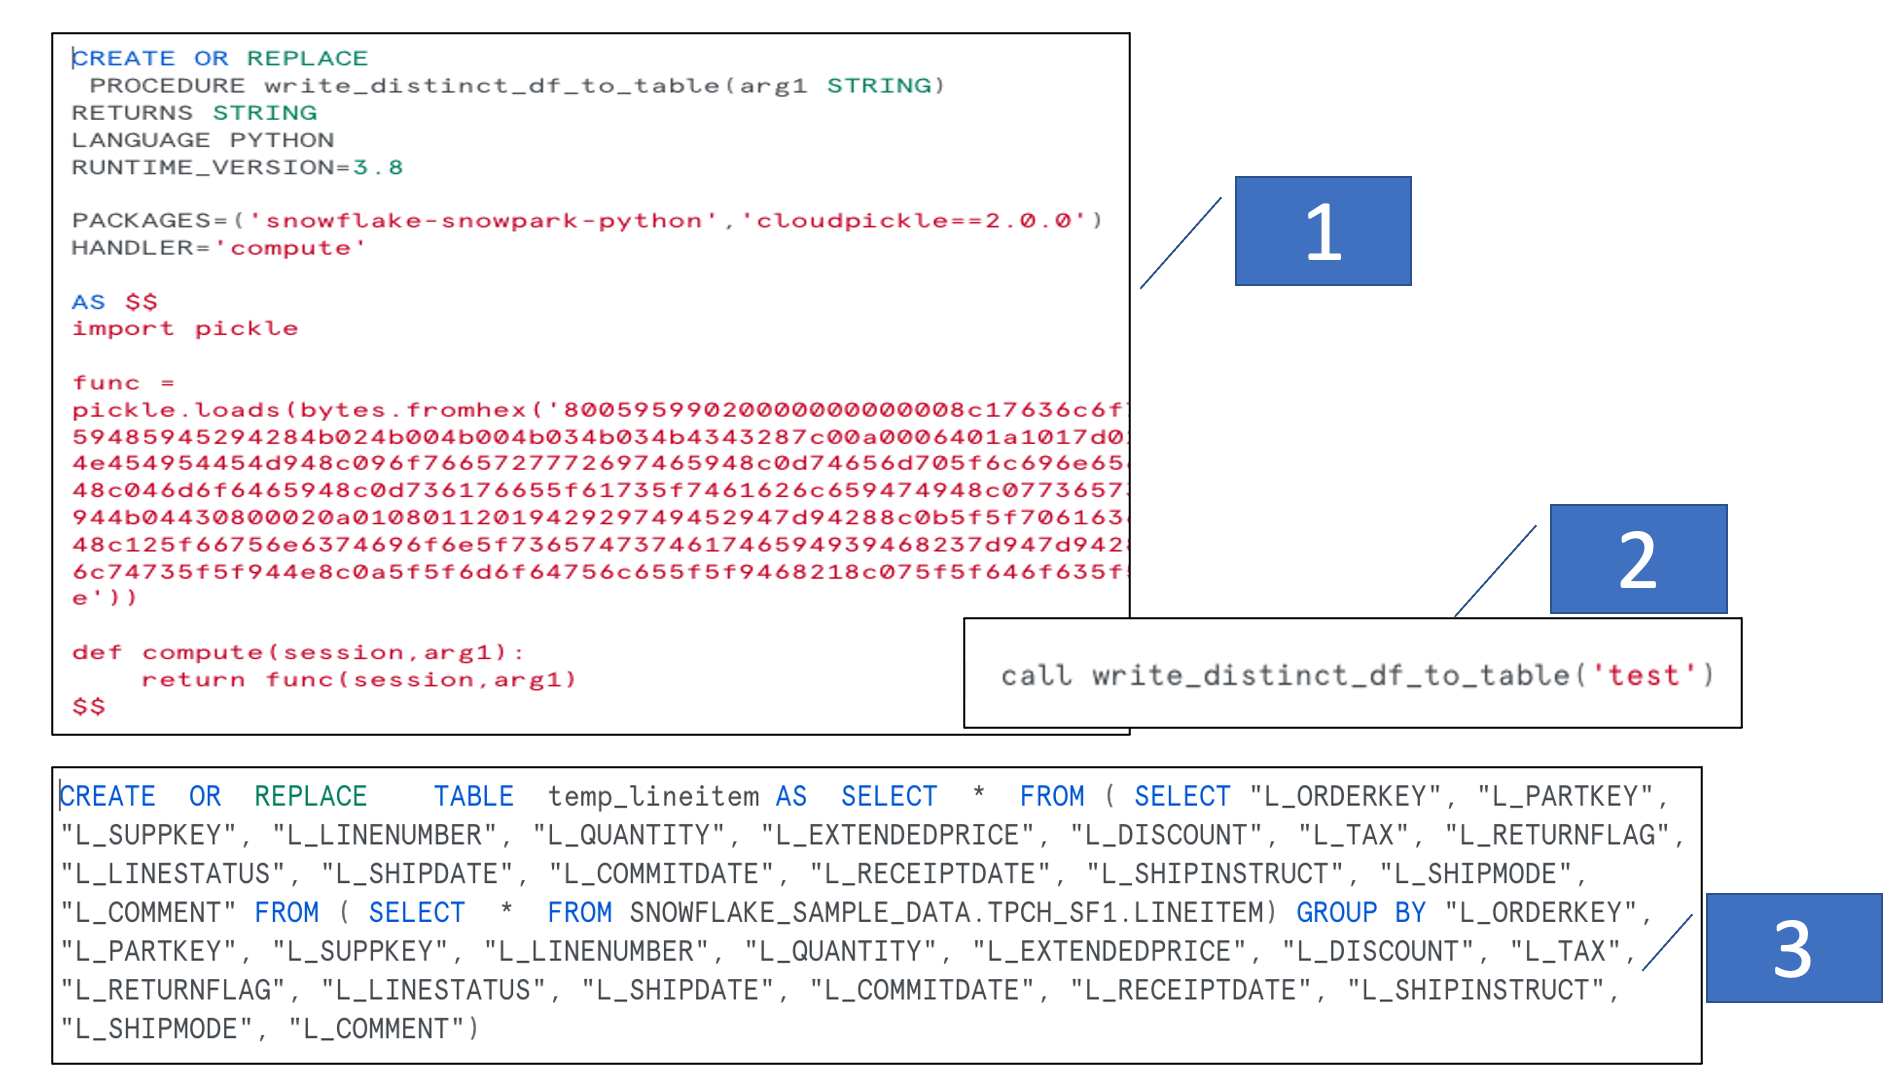

### <ins> STEP 3: Create a Stored Procedure to remove duplicates using Pandas Dataframe.</ins>

In [ ]:
%%time
import snowflake.snowpark
from snowflake.snowpark.functions import sproc

session.add_packages("snowflake-snowpark-python", "pandas")
@sproc(name="write_distinct_df_to_table", is_permanent=True, stage_location="@udf", replace=True, packages=["snowflake-snowpark-python"])
def write_distinct_df_to_table(session: snowflake.snowpark.Session, x: str) -> str:
    lineitem_df = session.table('SNOWFLAKE_SAMPLE_DATA.TPCH_SF1.LINEITEM')
    lineitem_pandasdf = lineitem_df.to_pandas()
    lineitem_pandasdf = lineitem_pandasdf.drop_duplicates()
    session.write_pandas(lineitem_pandasdf, "temp_lineitem", auto_create_table=True)
    return 'Table Created Sucessfully'
    
session.sql("call write_distinct_df_to_table('test')").collect()

In [ ]:
if session: # it is good to ensure there is NO ACTIVE SESSION when using Snowpark in notebook hence closing down any session for code reusablity
    session.close()